# Question 4: Classification and Policy Implications 
**Task:** 
Build a classifier to identify countries that are likely to achieve a significant reduction in 
CO2 emissions in the next decade. Answer the business case question: “What are the 
common characteristics of countries that successfully reduce emissions, and how can 
policymakers in other nations apply these insights?” 
 
**Instructions:** 
1. Define a binary target variable indicating whether a country is likely to reduce its CO2 
emissions significantly in the next decade. 
2. Train a classification model using the comprehensive set of indicators. 
3. Evaluate the classifier's performance using metrics like accuracy, precision, recall, and F1 
score. 
4. Analyze the key features driving the classification and identify common characteristics of 
successful countries. 
5. Provide policy recommendations based on the insights gained. 

**How to use**
- You can run all cells.
- Please refer to the deliverables folder and the [q4.md](deliverables/q4.md) file for an overview of the results of this first question.

**Comments**
- Does not run well with the groupping by country because there is very few data. We might need to test it with more countries. (df_grouped)
- Does work with historic data but I am not sure if this approach was correct. (df_merge)

In [35]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import numpy as np
from helpers_v2 import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
manipulate_data = DataManipulation()

In [4]:
df = pd.read_csv('clean_data/wbdata_no_log_transformation.csv')
df['id'] = df['country'] + '_' + df['date'].astype('string')
df.head()

,country,date,CO2_emissions,GDP,Population,Energy_use,Urbanization_rate,Renewable_elec_output,id
0,Australia,2015,385782.4,1.351769e+12,23815995.0,5483.816402,85.701,13.637841,Australia_2015
1,Australia,2014,379267.2,1.468598e+12,23475686.0,5334.681679,85.602,14.906712,Australia_2014
2,Australia,2013,388427.4,1.577302e+12,23128129.0,5468.391369,85.502,13.264108,Australia_2013
3,Australia,2012,395690.0,1.547650e+12,22733465.0,5575.287093,85.402,10.592653,Australia_2012
4,Australia,2011,394436.7,1.398701e+12,22340024.0,5745.232190,85.300,10.426652,Australia_2011


In [5]:
df_cotwo = df[['country', 'date', 'CO2_emissions']]
df_cotwo.head()

,country,date,CO2_emissions
0,Australia,2015,385782.4
1,Australia,2014,379267.2
2,Australia,2013,388427.4
3,Australia,2012,395690.0
4,Australia,2011,394436.7


In [6]:
df_cotwo_pivoted = df_cotwo.pivot(columns='date', index='country', values='CO2_emissions').reset_index()
df_cotwo_pivoted.head()

date,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Australia,263437.5,264709.7,268366.5,273016.9,280096.3,290141.5,300180.4,307778.5,327536.9,...,374104.4,384368.3,387570.3,393859.7,395993.2,394436.7,395690.0,388427.4,379267.2,385782.4
1,Austria,58275.7,62423.2,57668.0,57804.0,58288.2,61186.4,64902.9,64224.1,64673.1,...,74104.4,71248.0,70734.7,64420.7,69965.1,68276.0,65112.0,65752.7,62054.5,63254.7
2,Belgium,109312.6,113960.1,112329.3,110108.3,114901.4,114568.7,119448.4,116634.7,119412.8,...,108081.5,103905.8,106715.4,99904.4,106872.8,96488.2,95275.6,96550.6,90362.4,95096.0
3,Canada,419492.2,413298.6,426367.3,422047.8,436764.6,448046.0,461700.7,476815.9,484791.8,...,540525.6,571632.0,550553.2,521399.4,537091.5,549369.9,546291.6,555742.4,561760.5,558747.2
4,Chile,30533.6,29243.4,30346.9,32465.1,35826.8,38972.0,44896.3,51285.2,52013.7,...,57148.1,64574.0,67991.6,65450.6,69749.1,76470.5,78412.6,82998.5,76560.3,82260.4


In [77]:
df_cotwo_labeled = manipulate_data.q4_create_target_variable(df_cotwo_pivoted, start=2005, end=2015, threshold=-10)
df_cotwo_labeled.drop(columns='Percentage Change', inplace=True)
df_cotwo_labeled.head()

date,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Target
0,Australia,263437.5,264709.7,268366.5,273016.9,280096.3,290141.5,300180.4,307778.5,327536.9,...,384368.3,387570.3,393859.7,395993.2,394436.7,395690.0,388427.4,379267.2,385782.4,0
1,Austria,58275.7,62423.2,57668.0,57804.0,58288.2,61186.4,64902.9,64224.1,64673.1,...,71248.0,70734.7,64420.7,69965.1,68276.0,65112.0,65752.7,62054.5,63254.7,1
2,Belgium,109312.6,113960.1,112329.3,110108.3,114901.4,114568.7,119448.4,116634.7,119412.8,...,103905.8,106715.4,99904.4,106872.8,96488.2,95275.6,96550.6,90362.4,95096.0,1
3,Canada,419492.2,413298.6,426367.3,422047.8,436764.6,448046.0,461700.7,476815.9,484791.8,...,571632.0,550553.2,521399.4,537091.5,549369.9,546291.6,555742.4,561760.5,558747.2,0
4,Chile,30533.6,29243.4,30346.9,32465.1,35826.8,38972.0,44896.3,51285.2,52013.7,...,64574.0,67991.6,65450.6,69749.1,76470.5,78412.6,82998.5,76560.3,82260.4,0


In [78]:
df_cotwo_labeled.Target.value_counts()

Target
1    21
0    17
Name: count, dtype: int64

In [108]:

df_cotwo_unpivot = pd.melt(df_cotwo_labeled, id_vars=['country', 'Target'], var_name='date', value_name='CO2_emissions')
df_cotwo_unpivot['id'] = df_cotwo_unpivot['country'] + '_' + df_cotwo_unpivot['date'].astype('string')
df_cotwo_unpivot.head()

,country,Target,date,CO2_emissions,id
0,Australia,0,1990,263437.5,Australia_1990
1,Austria,1,1990,58275.7,Austria_1990
2,Belgium,1,1990,109312.6,Belgium_1990
3,Canada,0,1990,419492.2,Canada_1990
4,Chile,0,1990,30533.6,Chile_1990


In [70]:
df_cotwo_unpivot = df_cotwo_unpivot.drop(columns=['country', 'date', 'CO2_emissions'])
df_cotwo_unpivot.head()

,Target,id
0,0,Australia_1990
1,1,Austria_1990
2,1,Belgium_1990
3,0,Canada_1990
4,0,Chile_1990


In [71]:
df_merge = pd.merge(df, df_cotwo_unpivot)
df_merge.head()

,country,date,CO2_emissions,GDP,Population,Energy_use,Urbanization_rate,Renewable_elec_output,id,Target
0,Australia,2015,385782.4,1.351769e+12,23815995.0,5483.816402,85.701,13.637841,Australia_2015,0
1,Australia,2014,379267.2,1.468598e+12,23475686.0,5334.681679,85.602,14.906712,Australia_2014,0
2,Australia,2013,388427.4,1.577302e+12,23128129.0,5468.391369,85.502,13.264108,Australia_2013,0
3,Australia,2012,395690.0,1.547650e+12,22733465.0,5575.287093,85.402,10.592653,Australia_2012,0
4,Australia,2011,394436.7,1.398701e+12,22340024.0,5745.232190,85.300,10.426652,Australia_2011,0


In [72]:
df_merge.rename(columns={'Target': 'reduced_cotwo_emi'}, inplace=True)
df_merge['reduced_cotwo_emi'].value_counts()

reduced_cotwo_emi
1    598
0    390
Name: count, dtype: int64

In [82]:
df_merge = df_merge.drop(columns='id')
df_merge.head()

,country,date,CO2_emissions,GDP,Population,Energy_use,Urbanization_rate,Renewable_elec_output,reduced_cotwo_emi
0,Australia,2015,385782.4,1.351769e+12,23815995.0,5483.816402,85.701,13.637841,0
1,Australia,2014,379267.2,1.468598e+12,23475686.0,5334.681679,85.602,14.906712,0
2,Australia,2013,388427.4,1.577302e+12,23128129.0,5468.391369,85.502,13.264108,0
3,Australia,2012,395690.0,1.547650e+12,22733465.0,5575.287093,85.402,10.592653,0
4,Australia,2011,394436.7,1.398701e+12,22340024.0,5745.232190,85.300,10.426652,0


In [87]:
df_filtered = df_merge[(df_merge['date'] >= 2005) & (df_merge['date'] <= 2015)]
df_grouped = df_filtered.groupby(['country', 'reduced_cotwo_emi']).median().reset_index()

df_grouped.head()

,country,reduced_cotwo_emi,date,CO2_emissions,GDP,Population,Energy_use,Urbanization_rate,Renewable_elec_output
0,Australia,0,2010.0,387570.3,1.148890e+12,22031750.0,5745.232190,85.182,9.299308
1,Austria,1,2010.0,68276.0,4.017587e+11,8363404.0,3921.900515,57.683,69.230888
2,Belgium,1,2010.0,99904.4,4.832542e+11,10895586.0,5196.581983,97.651,6.920806
3,Canada,0,2010.0,549369.9,1.556509e+12,34005902.0,7898.606527,80.937,62.338250
4,Chile,0,2010.0,69749.1,2.170512e+11,17004162.0,1856.397348,87.074,43.604335


In [88]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                38 non-null     object 
 1   reduced_cotwo_emi      38 non-null     int64  
 2   date                   38 non-null     float64
 3   CO2_emissions          38 non-null     float64
 4   GDP                    38 non-null     float64
 5   Population             38 non-null     float64
 6   Energy_use             38 non-null     float64
 7   Urbanization_rate      38 non-null     float64
 8   Renewable_elec_output  38 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.8+ KB


In [92]:
df_merge_log = manipulate_data.log_transformation(df_grouped, cols_to_transform=['CO2_emissions', 'GDP', 'Population', 'Energy_use'])
df_merge_log = df_merge_log.drop(columns=['CO2_emissions', 'GDP', 'Population', 'Energy_use'])
df_merge_log.head()

,country,reduced_cotwo_emi,date,Urbanization_rate,Renewable_elec_output,log_CO2_emissions,log_GDP,log_Population,log_Energy_use
0,Australia,0,2010.0,85.182,9.299308,12.867655,27.769818,16.907995,8.656300
1,Austria,1,2010.0,57.683,69.230888,11.131328,26.719118,15.939376,8.274587
2,Belgium,1,2010.0,97.651,6.920806,11.511979,26.903809,16.203868,8.555949
3,Canada,0,2010.0,80.937,62.338250,13.216529,28.073466,17.342045,8.974568
4,Chile,0,2010.0,87.074,43.604335,11.152674,26.103399,16.648969,7.526932


In [95]:
plot_maker = MultiplePlotMaker(df=df_merge_log.drop(columns=['country', 'date']))

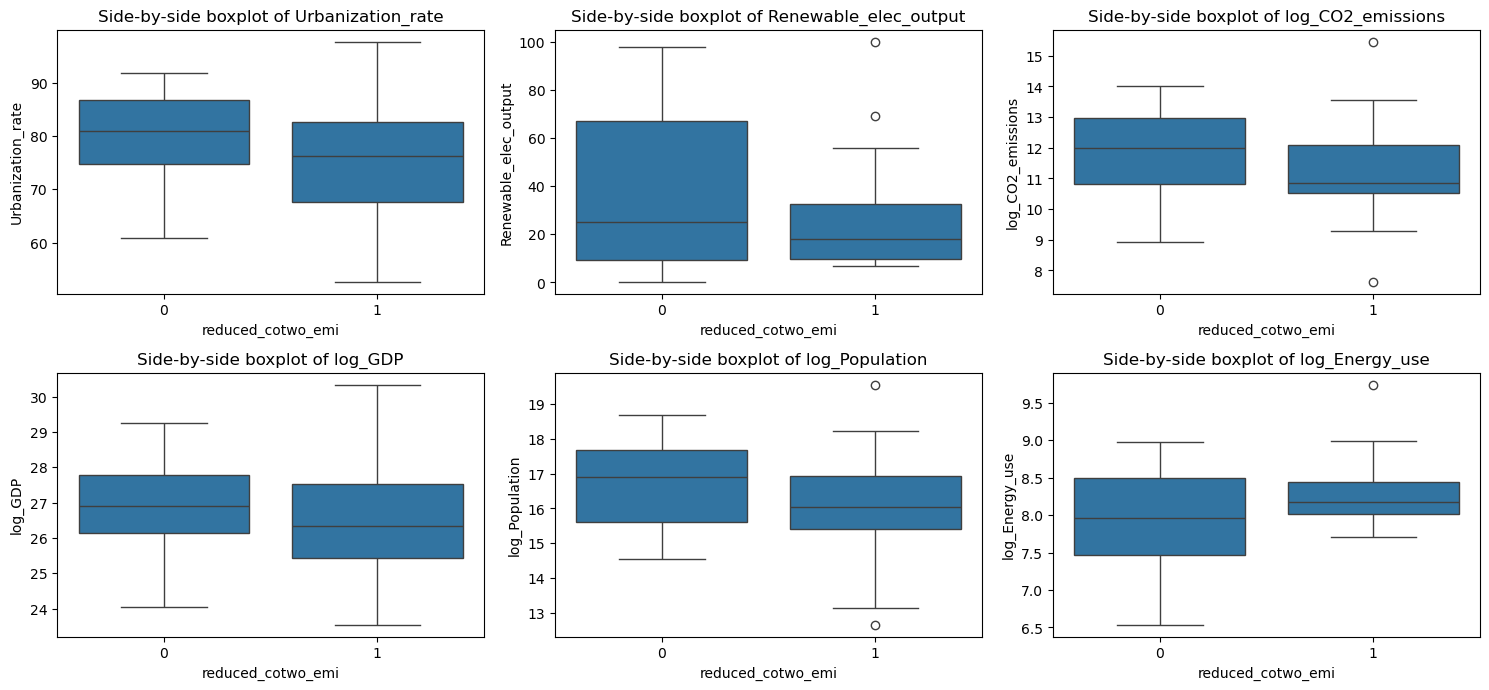

In [96]:
plot_maker.plot_multiple_side_by_side_boxplots(target_variable_name='reduced_cotwo_emi')

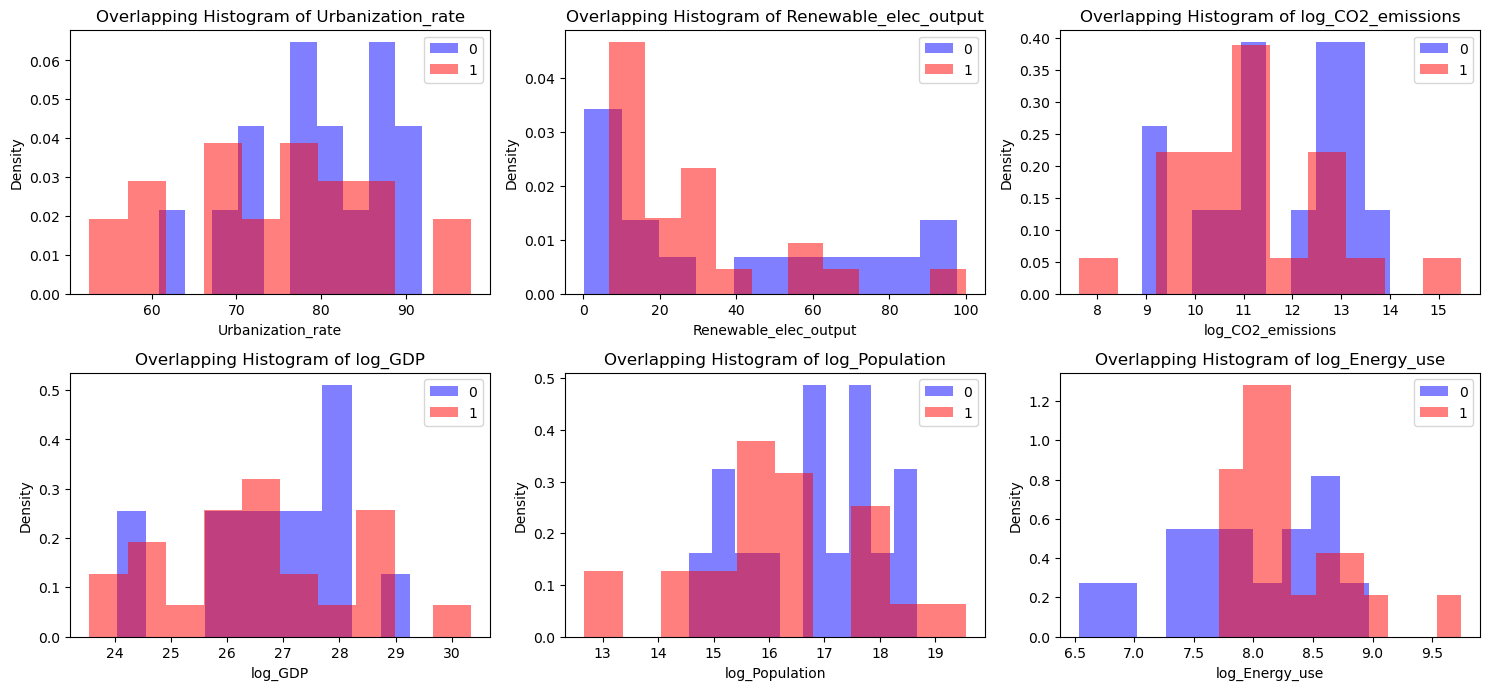

In [97]:
plot_maker.plot_multiple_overlapping_hist(target_variable_name='reduced_cotwo_emi')

### Key Features
- Renewable electricity output: definetly impacts. It seems that the countries with highest renewable electricity output haven't mitigated the CO2 emissions by 10 percent. This suggest that either there is an error because it seems counterintuitive or that renewable electricity is not enough to mitigate CO2 emissions.
- CO2 Emissions: not that much
- Population: not that much
- Energy use: not that much
- Urbanization rate: not that much
- GDP: it does have certain impact

In [103]:
X = df_merge.drop(columns=['country', 'date', 'reduced_cotwo_emi'])
y = df_merge['reduced_cotwo_emi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [104]:
pipeline_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

pipeline_knn = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', KNeighborsClassifier())
])

pipeline_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', SVC(random_state=42))
])


In [105]:
pipelines = [pipeline_lr, pipeline_knn, pipeline_svm]
pipeline_names = ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine']

for pipeline, name in zip(pipelines, pipeline_names):
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Logistic Regression Cross-Validation Accuracy: 0.7899 ± 0.0194
K-Nearest Neighbors Cross-Validation Accuracy: 0.9924 ± 0.0047
Support Vector Machine Cross-Validation Accuracy: 0.8848 ± 0.0417


In [106]:
best_pipeline = pipeline_svm

# Train the best model on the entire training set
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Test Set Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Best Model Test Set Accuracy: 0.9091
              precision    recall  f1-score   support

           0       0.97      0.79      0.87        78
           1       0.88      0.98      0.93       120

    accuracy                           0.91       198
   macro avg       0.92      0.89      0.90       198
weighted avg       0.92      0.91      0.91       198

[[ 62  16]
 [  2 118]]


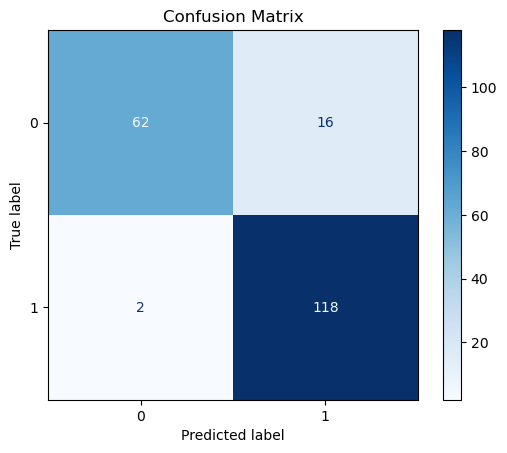

In [107]:
cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()